# TCC


Ref Github: https://github.com/lszam/mineralexp

In [ ]:
import os
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pyproj
from warnings import filterwarnings

# import rasterio
# from rasterio.features import rasterize
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_curve, auc
# from sklearn.cluster import KMeans
# from imblearn.under_sampling import RandomUnderSampler

filterwarnings('ignore')

In [2]:
dir_projeto = Path(os.getcwd()).parent.absolute()
data_dir = Path(dir_projeto, "Output", "tcc")
shp_dir = Path(data_dir, 'shp')

## funções

In [3]:
def utm_to_latlon(df: pd.DataFrame, x_col: str='X', y_col: str='Y', utm_zone: int=22, southern_hemisphere: bool=True):
    """
    Convert UTM coordinates to latitude/longitude (WGS84)

    Parameters:
    - df: DataFrame containing coordinates
    - x_col: Column name for easting (UTM X)
    - y_col: Column name for northing (UTM Y)
    - utm_zone: UTM zone number (Brazil is mostly zones 22-25)
    - southern_hemisphere: True for southern hemisphere (Brazil)

    Returns:
    DataFrame with new 'longitude' and 'latitude' columns
    """
    # Create UTM coordinate system
    utm = pyproj.Proj(proj='utm', zone=utm_zone, south=southern_hemisphere)

    # Create WGS84 coordinate system
    wgs84 = pyproj.Proj(proj='latlong', datum='WGS84')

    # Convert coordinates
    lon, lat = pyproj.transform(utm, wgs84, df[x_col].values, df[y_col].values)

    # Add to DataFrame
    df = df.copy()
    df['longitude'] = lon
    df['latitude'] = lat

    return df


def convert_shapefile_to_latlon(shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs is None:
        # Assuming it's in the same UTM as your other data
        gdf.crs = f"+proj=utm +zone=22 +south +datum=WGS84 +units=m +no_defs"
    gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)
    return gdf

## leitura e processamento

- leitura dos dados de espectrometria

  - dados:
    - Fator F: valores altos para rochas alteradas por fluidos que carregam metais
    - Kd: abundância de potássio
    - Ud: abundância de urânio

In [4]:
spec_data = pd.read_csv(
    Path(data_dir, "dados_gamaespectrometria_filtrados.csv"),
    dtype={
        "XUTM": np.float32,
        "YUTM": np.float32,
        "FatorF": np.float32,
        "Kd": np.float32,
        "Ud": np.float32,
    },
)
# spec_data.rename(columns={"XUTM": "X", "YUTM": "Y"}, inplace=True)
spec_data = utm_to_latlon(spec_data, x_col='XUTM', y_col='YUTM')
spec_data.head()

/tmp/ipykernel_31432/2720471530.py:22: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = pyproj.transform(utm, wgs84, df[x_col].values, df[y_col].values)


,XUTM,YUTM,FatorF,Kd,Ud,longitude,latitude
0,279545.71875,9101977.0,0.001366,-71.005653,-0.349341,-53.00070,-8.119232
1,279681.28125,9101978.0,0.003305,-28.235151,-0.366232,-52.99947,-8.119229
2,279816.87500,9101979.0,0.005131,-17.356588,-0.394505,-52.99824,-8.119227
3,279952.46875,9101979.0,0.007127,-11.845008,-0.430501,-52.99701,-8.119233
4,280088.06250,9101980.0,0.009410,-8.448283,-0.474455,-52.99578,-8.119230


- leitura dos dados de gravimetria

  - dados:
    - grav_residual190km_qht: Gravity residual at 190km (possibly Bouguer anomaly)
    - grav_residual100km: Gravity residual at 100km
    - maq_asvi: Likely some gravity-related index or processed value
    - maq_qt: Another gravity-related metric, possibly quality or quantity measure

In [5]:
grav_data = pd.read_csv(
    Path(data_dir, "dados_gravmag_filtrados_v2.csv"),
    dtype={
        "X": np.float32,
        "Y": np.float32,
        "grav_residual190km_ght": np.float32,
        "grav_residual100km": np.float32,
        "mag_asvi": np.float32,
        "mag_gt": np.float32,
    },
)
grav_data = utm_to_latlon(grav_data, x_col='X', y_col='Y')
grav_data.head()

/tmp/ipykernel_31432/2720471530.py:22: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = pyproj.transform(utm, wgs84, df[x_col].values, df[y_col].values)


,X,Y,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,longitude,latitude
0,453679.25,9102751.0,0.000501,-1.943505,67.472176,0.008145,-51.420454,-8.116933
1,454429.25,9102751.0,0.000573,-1.592606,64.604439,0.008208,-51.413646,-8.116940
2,455179.25,9102751.0,0.000563,-1.343595,62.171368,0.008150,-51.406838,-8.116947
3,455929.25,9102751.0,0.000560,-1.101486,60.097729,0.008015,-51.400031,-8.116953
4,456679.25,9102751.0,0.000559,-0.847108,58.177116,0.007754,-51.393223,-8.116960


- leitura dos shapefiles com ocorrências de metais/minas

In [6]:
# ouro = gpd.read_file(Path(shp_dir, 'ocorrencias_Au.shp'))
# # cobre = gpd.read_file(Path(shp_dir, 'ocorrencias_Cu.shp'))
# ferro = gpd.read_file(Path(shp_dir, 'ocorrencias_Fe.shp'))
# # manganes = gpd.read_file(Path(shp_dir, 'ocorrencias_Mn.shp'))
# # niquel = gpd.read_file(Path(shp_dir, 'ocorrencias_Ni.shp'))
# # chumbo = gpd.read_file(Path(shp_dir, 'ocorrencias_Pb.shp'))
# # estanho = gpd.read_file(Path(shp_dir, 'ocorrencias_Sn.shp'))

# minas = gpd.read_file(Path(shp_dir, 'minas.shp'))

# ! leitura dos arquivos com conversão para latitude/longitude
ouro = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Au.shp'))
# cobre = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Cu.shp'))
ferro = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Fe.shp'))
# manganes = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Mn.shp'))
# niquel = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Ni.shp'))
# chumbo = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Pb.shp'))
# estanho = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Sn.shp'))

minas = convert_shapefile_to_latlon(Path(shp_dir, 'minas.shp'))

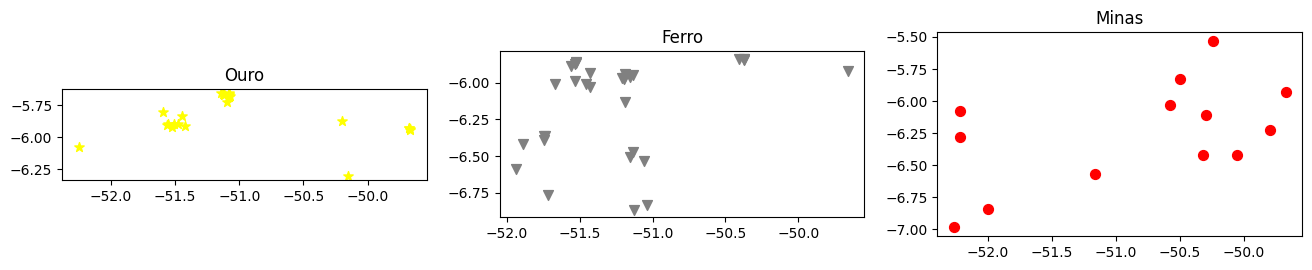

In [8]:
# https://matplotlib.org/stable/api/markers_api.html

lst_data = [ouro, ferro, minas]
lst_cores = ['yellow', 'gray', 'red']
lst_marker = ['*', 'v', 'o']
lst_nomes = ['Ouro', 'Ferro', 'Minas']

fig, axs = plt.subplots(1, 3, figsize=(16, 10))
for i, ax in enumerate(axs.flatten()):
    lst_data[i].plot(ax=ax, color=lst_cores[i], marker=lst_marker[i], markersize=50)
    ax.set_title(lst_nomes[i])